# 📰 Fake News Detection using Machine Learning


## 🔍 Loading and Labeling Dataset
We use two datasets: `Fake.csv` and `True.csv`.  
Each dataset is labeled (0 = Fake, 1 = Real) and then merged and shuffled.


In [1]:
import zipfile

# Unzip Fake.csv.zip
with zipfile.ZipFile("Fake.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Unzip True.csv.zip
with zipfile.ZipFile("True.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [2]:
import pandas as pd

# Load both files
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

# Add a label column to each
fake_df['label'] = 0  # Fake = 0
real_df['label'] = 1  # Real = 1

# Combine datasets
df = pd.concat([fake_df, real_df])

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# Display basic info
df.head()

,title,text,subject,date,label
0,ONE IMAGE PERFECTLY Captures Who’s Really Behi...,Unfounded claims that President Trump was film...,left-news,"Dec 8, 2017",0
1,"Clinton to meet with presidents of Egypt, Ukra...","WHITE PLAINS, New York (Reuters) - Democratic ...",politicsNews,"September 14, 2016",1
2,"Trump adviser: TPP 'dead,' will move quickly o...",WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"January 13, 2017",1
3,"MY POPE JUST INVITED A RADICAL, Pro-Abortion S...",Funny I seem to remember being taught as a you...,politics,"Apr 8, 2016",0
4,Trump taps Montana Congressman Zinke to lead I...,WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"December 15, 2016",1


In [3]:
df.info()
df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


,count
label,
0,23481
1,21417


In [4]:
!pip install nltk

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # Optional for tokenizing words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 🧹 Text Cleaning
We apply Natural Language Processing (NLP) to:
- Convert text to lowercase
- Remove punctuation/symbols
- Remove stopwords
- Combine title and text


In [6]:
import re
from nltk.corpus import stopwords

In [7]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation, symbols, links
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [8]:
df['combined'] = df['title'] + ' ' + df['text']
df['clean_text'] = df['combined'].apply(clean_text)

## 📊 Text Vectorization using TF-IDF
We convert cleaned text into numbers using TF-IDF to feed into the model.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer(max_df=0.7)  # Ignore overly common words

In [11]:
X = vectorizer.fit_transform(df['clean_text'])  # Features
y = df['label']  # Target (0 = Fake, 1 = Real)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 🤖 Model Training - Naive Bayes
A Naive Bayes classifier is trained to detect whether a news article is real or fake.


In [13]:
from sklearn.naive_bayes import MultinomialNB

In [14]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [15]:
y_pred = model.predict(X_test)

## 📈 Model Evaluation
We evaluate the model using:
- Accuracy
- Classification Report
- Confusion Matrix


In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.945924276169265

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      5877
           1       0.94      0.95      0.94      5348

    accuracy                           0.95     11225
   macro avg       0.95      0.95      0.95     11225
weighted avg       0.95      0.95      0.95     11225



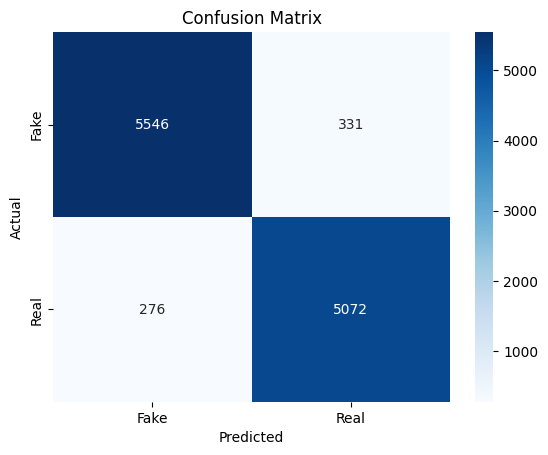

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 🔮 Manual Prediction System
Enter any news text and let the model tell if it's FAKE or REAL.


In [18]:
def predict_news(news):
    cleaned = clean_text(news)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)
    return "REAL" if prediction[0] == 1 else "FAKE"

# Example usage
news_input = "Breaking: President announces new economic reforms for stability."
print("Prediction:", predict_news(news_input))

Prediction: REAL


In [19]:
!pip install gradio

## 🖥️ Live Demo - Web App Interface (Gradio)
This is a simple web app that allows you to test the model by typing a news sentence.


In [20]:
import gradio as gr

def gradio_predict(news):
    cleaned = clean_text(news)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)
    return "✅ REAL News" if prediction[0] == 1 else "🚫 FAKE News"

# Launch app
interface = gr.Interface(fn=gradio_predict,
                         inputs="text",
                         outputs="text",
                         title="📰 Fake News Detector",
                         description="Enter a news headline or paragraph to predict if it's real or fake.")

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3417569f0f1f620856.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [21]:
examples = [
    "Aliens took over the National Assembly last night.",
    "The Prime Minister will address the nation at 8 PM.",
    "Government announces free internet for every village.",
    "Bill Gates visits Pakistan to launch new vaccine.",
    "Scientists confirm that water is no longer wet.",
    "Pakistan to colonize the moon by 2027.",
    "Punjab University will be converted into a space lab.",
    "The President of France resigns after losing chess match.",
    "Shahid Afridi appointed as NASA’s chief scientist.",
    "UN confirms peace mission in Gaza will start next week."
]

for news in examples:
    print(news, "=>", predict_news(news))

Aliens took over the National Assembly last night. => FAKE
The Prime Minister will address the nation at 8 PM. => REAL
Government announces free internet for every village. => FAKE
Bill Gates visits Pakistan to launch new vaccine. => REAL
Scientists confirm that water is no longer wet. => FAKE
Pakistan to colonize the moon by 2027. => REAL
Punjab University will be converted into a space lab. => REAL
The President of France resigns after losing chess match. => REAL
Shahid Afridi appointed as NASA’s chief scientist. => REAL
UN confirms peace mission in Gaza will start next week. => REAL
